# Flat Price Analysis in Moscow


## Table of Contents
1. [Introduction](#Introduction)
2. [Data Collection](#Data-Collection)
3. [Data Preparation](#Data-Preparation)
4. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
5. [Conclusion](#Conclusion)
6. [References](#References)


## Introduction 

This notebook analyzes flat prices in Moscow using data from CianParser. The goal is to understand the distribution of flat prices, perform exploratory data analysis, and visualize the results.

## Data Collection
In this section, data is collected using the CianParser library.

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import geopandas as gpd

import cianparser

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from adjustText import adjust_text
from sklearn.linear_model import LinearRegression


In [2]:
# Init parser
moscow_parser = cianparser.CianParser(location="Москва")

In [3]:
# Get .csv file of flat rents
moscow_parser.get_flats(deal_type="rent_long", rooms=(1,2), with_saving_csv=True, additional_settings= {"start_page":1, "end_page":20})

In [4]:
# Get .csv file of flat sales
moscow_parser.get_flats(deal_type="sale", rooms=(1,2), with_saving_csv=True, additional_settings= {"start_page":2, "end_page":20})

## Data Preparation
There I create DataFrames for each file and change name of `rent_df` column, so that it is the same as in `sales_df`.

In [5]:
# Create DataFrame for each .csv file
rent_df = pd.read_csv("./data/cian_flat_rent_1_20_moskva_01_Feb_2025_01_21_02_822813.csv",delimiter=";").dropna()
rent_df.rename(columns={'price_per_month': 'price'}, inplace=True)

sales_df = pd.read_csv("./data/cian_flat_sale_2_20_moskva_01_Feb_2025_01_23_31_521792.csv",delimiter=";").dropna()

In [6]:
# Columns of DataFrames
print(rent_df.columns)
print(sales_df.columns)

Index(['author', 'author_type', 'url', 'location', 'deal_type',
       'accommodation_type', 'floor', 'floors_count', 'rooms_count',
       'total_meters', 'price', 'commissions', 'district', 'street',
       'house_number', 'underground'],
      dtype='object')
Index(['author', 'author_type', 'url', 'location', 'deal_type',
       'accommodation_type', 'floor', 'floors_count', 'rooms_count',
       'total_meters', 'price', 'district', 'street', 'house_number',
       'underground', 'residential_complex'],
      dtype='object')


## Exploratory Data Analysis

### Prices for flats for rent

In this section, I analyzing prices for rent and trying to figure out what it depends on.

In [7]:
# Descriptive statistics
rent_df['price'].describe()

count        424.000000
mean      130197.707547
std       102676.032078
min        34800.000000
25%        65000.000000
50%        94700.000000
75%       148500.000000
max      1000000.000000
Name: price, dtype: float64

As we can see, mean price for renting a one-room or two-room flat in Moscow is 130k rub per month (≈1300$), which is quite a lot (mean salary in Moscow is 150k rub). But max price is one million rub, so I can assume, that there is some outliers in data, which spoil the mean value. To check it I will draw a boxplot, which will show this outliers.


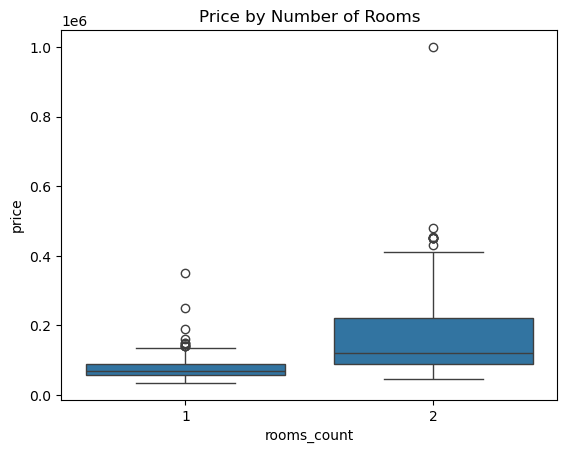

In [8]:
# Box plot: price by rooms_count
sns.boxplot(x='rooms_count', y='price', data=rent_df)
plt.title('Price by Number of Rooms')
plt.show()

There we can see, that there is really one outlier. Let`s check, why price is so high.


In [9]:
# Finding url of this rent
rent_df[rent_df['price'] == 1000000]['url']

96    https://www.cian.ru/rent/flat/312622823/
Name: url, dtype: object

As we can see, this flat is in the center of Moscow with great view and also with parking space in the underground parking.

Now I want to check, which features influence price the most. I will analyze this characteristics:
- Property characteristics: `rooms_count`, `total_meters`, `floor`, `floors_count`
- Location-related features: `district`, `street`, `underground`

#### Property characteristics

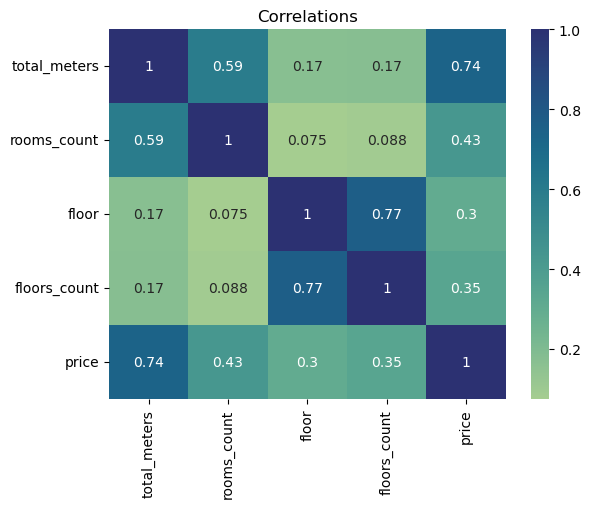

In [10]:
# Correlation matrix
corr_matrix = rent_df[['total_meters', 'rooms_count', 'floor', 'floors_count', 'price']].corr()
sns.heatmap(corr_matrix, cmap='crest', annot=True)
plt.title('Correlations')
plt.show()

As we can see, the most correlation is between price and total meters and least is with floor and floors count. 

Now I want to use linear regression to see coefficients of each characteristic.

In [11]:
# Linear regression
X = rent_df[['total_meters', 'rooms_count', 'floor', 'floors_count']]
y = rent_df['price']
model = LinearRegression()
model.fit(X, y)
print("Coefficients:", model.coef_)

Coefficients: [ 3370.64987954 -2131.93246513   260.16289839  1139.042496  ]


From linear regression we can see, that for every additional square meter (`total_meters`), the monthly rental price increases by 3370.65 rub, assuming all other variables remain constant. Also we can see one counterintuitive result (for `rooms_count` coeff is -2131). It can indicate that properties with more rooms (but the same total size) are less desirable or located in less expensive areas. It also can indicate that in this collected data there are not many two-rooms flats.

#### Location-related features

To check Location-related features I will draw a map of Moscow and highlight each district with color, that will show a mean price for rent in this district. For this I will use GeoPandas and map of Moscow from [this repository](https://github.com/timurkanaz/Russia_geojson_OSM).

In [12]:
# Create GeoDataFrame of all Moscow districts
MSC = gpd.read_file("data/moscow.geojson")

# Format names of districts to match data from CianParser
def format_district(s : str):
    return s.replace('район ','')

MSC['district'] = MSC['district'].apply(format_district)

Then I will create some functions to draw Moscow map with mean prices.

In [13]:
def format_price(x):
    if x>=1000000:
        return str(round(x/1000000))+'m'
    if x>=1000:
        return str(round(x/1000))+'k'
    return x

def calculate_mean_prices(data: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate mean flat prices for each district.
    """

    return data.groupby('district')['price'].mean().round(0).reset_index()

def prepare_map_data(msc_data : gpd.GeoDataFrame, mean_df : pd.DataFrame) -> pd.DataFrame:
    """
    Prepare map data by exploding MultiPolygons, calculating centroids,
    and merging with mean prices.
    """
    msc_exploded = msc_data.explode(index_parts=True)
    msc_exploded['centroid'] = msc_exploded.geometry.centroid
    merged_df = pd.merge(msc_exploded, mean_df, on='district', how='left').dropna().reset_index()
    return merged_df

def create_legend_labels(merged_df: pd.DataFrame, cmap, norm) -> list:
    """
    Create legend labels and patches for the map.
    """
    legend_labels = []
    for i, (idx, row) in enumerate(merged_df.drop_duplicates(subset=['district']).iterrows(), start=1):
        district_name = row['district']
        mean_cost = row['price']
        label = f'{i}: {district_name} ({format_price(mean_cost)} руб)'
        color = cmap(norm(mean_cost))
        patch = mpatches.Patch(color=color, label=label)
        legend_labels.append(patch)
    return legend_labels


def add_district_labels(ax, merged_df: pd.DataFrame):
    """
    Add district labels to the map and adjust text to avoid overlaps.
    """
    district_id_map = {}  # Maps district names to their IDs
    texts = []

    for idx, row in merged_df.iterrows():
        district_name = row['district']
        
        # Assign a unique ID to each district
        if district_name not in district_id_map:
            district_id_map[district_name] = len(district_id_map) + 1
        
        district_id = district_id_map[district_name]
        
        # Add the label to the map
        text = ax.text(row['centroid'].x, row['centroid'].y, str(district_id), fontsize=8, ha='center')
        texts.append(text)
        

    # Adjust text to avoid overlaps
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))


def draw_map(data : pd.DataFrame, msc_data : gpd.GeoDataFrame, header : str, figsize=(20,20)):
    """
    Draw a map of Moscow with highlighted regions based on mean flat prices.

    # Parameters:
    - data: DataFrame containing district and price_per_month data.
    - msc_data: GeoDataFrame containing Moscow district geometries.
    - header: Title of the map.
    - figsize: Size of the figure (default: (20, 20)).
    """


    # Calculate mean price
    mean_df = calculate_mean_prices(data)

    # Prepare map data
    merged_df = prepare_map_data(msc_data, mean_df)

    # Normalize the price data for the colormap
    norm = Normalize(vmin=merged_df['price'].min(), vmax=merged_df['price'].max())
    cmap = plt.cm.Paired  

    # Create legend labels
    legend_labels = create_legend_labels(merged_df, cmap, norm)

    # Draw the map
    fig, ax = plt.subplots(figsize=figsize)
    msc_data.plot(ax=ax, color='white', edgecolor='black')


    # Draw districts with colors based on mean price
    merged_df.plot(
        ax=ax,
        column='price',
        cmap=cmap,
        legend=False,
        linewidth=0.5,
        norm=norm  # Apply normalization
    )

    # Add district labels
    add_district_labels(ax, merged_df)

    # Add legend 
    ax.legend(
        handles=legend_labels,
        loc='lower right',
        ncol=len(merged_df.columns),
        fancybox=True,
        fontsize=8
    )

    # Add a colorbar for the colormap
    sm = ScalarMappable(norm=norm, cmap=cmap)
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label(f'price (rub)', fontsize=12)

    # Set title
    plt.title(header, fontsize=15)

    plt.show()

Let`s draw the map!

/tmp/ipykernel_3383/946895084.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  msc_exploded['centroid'] = msc_exploded.geometry.centroid


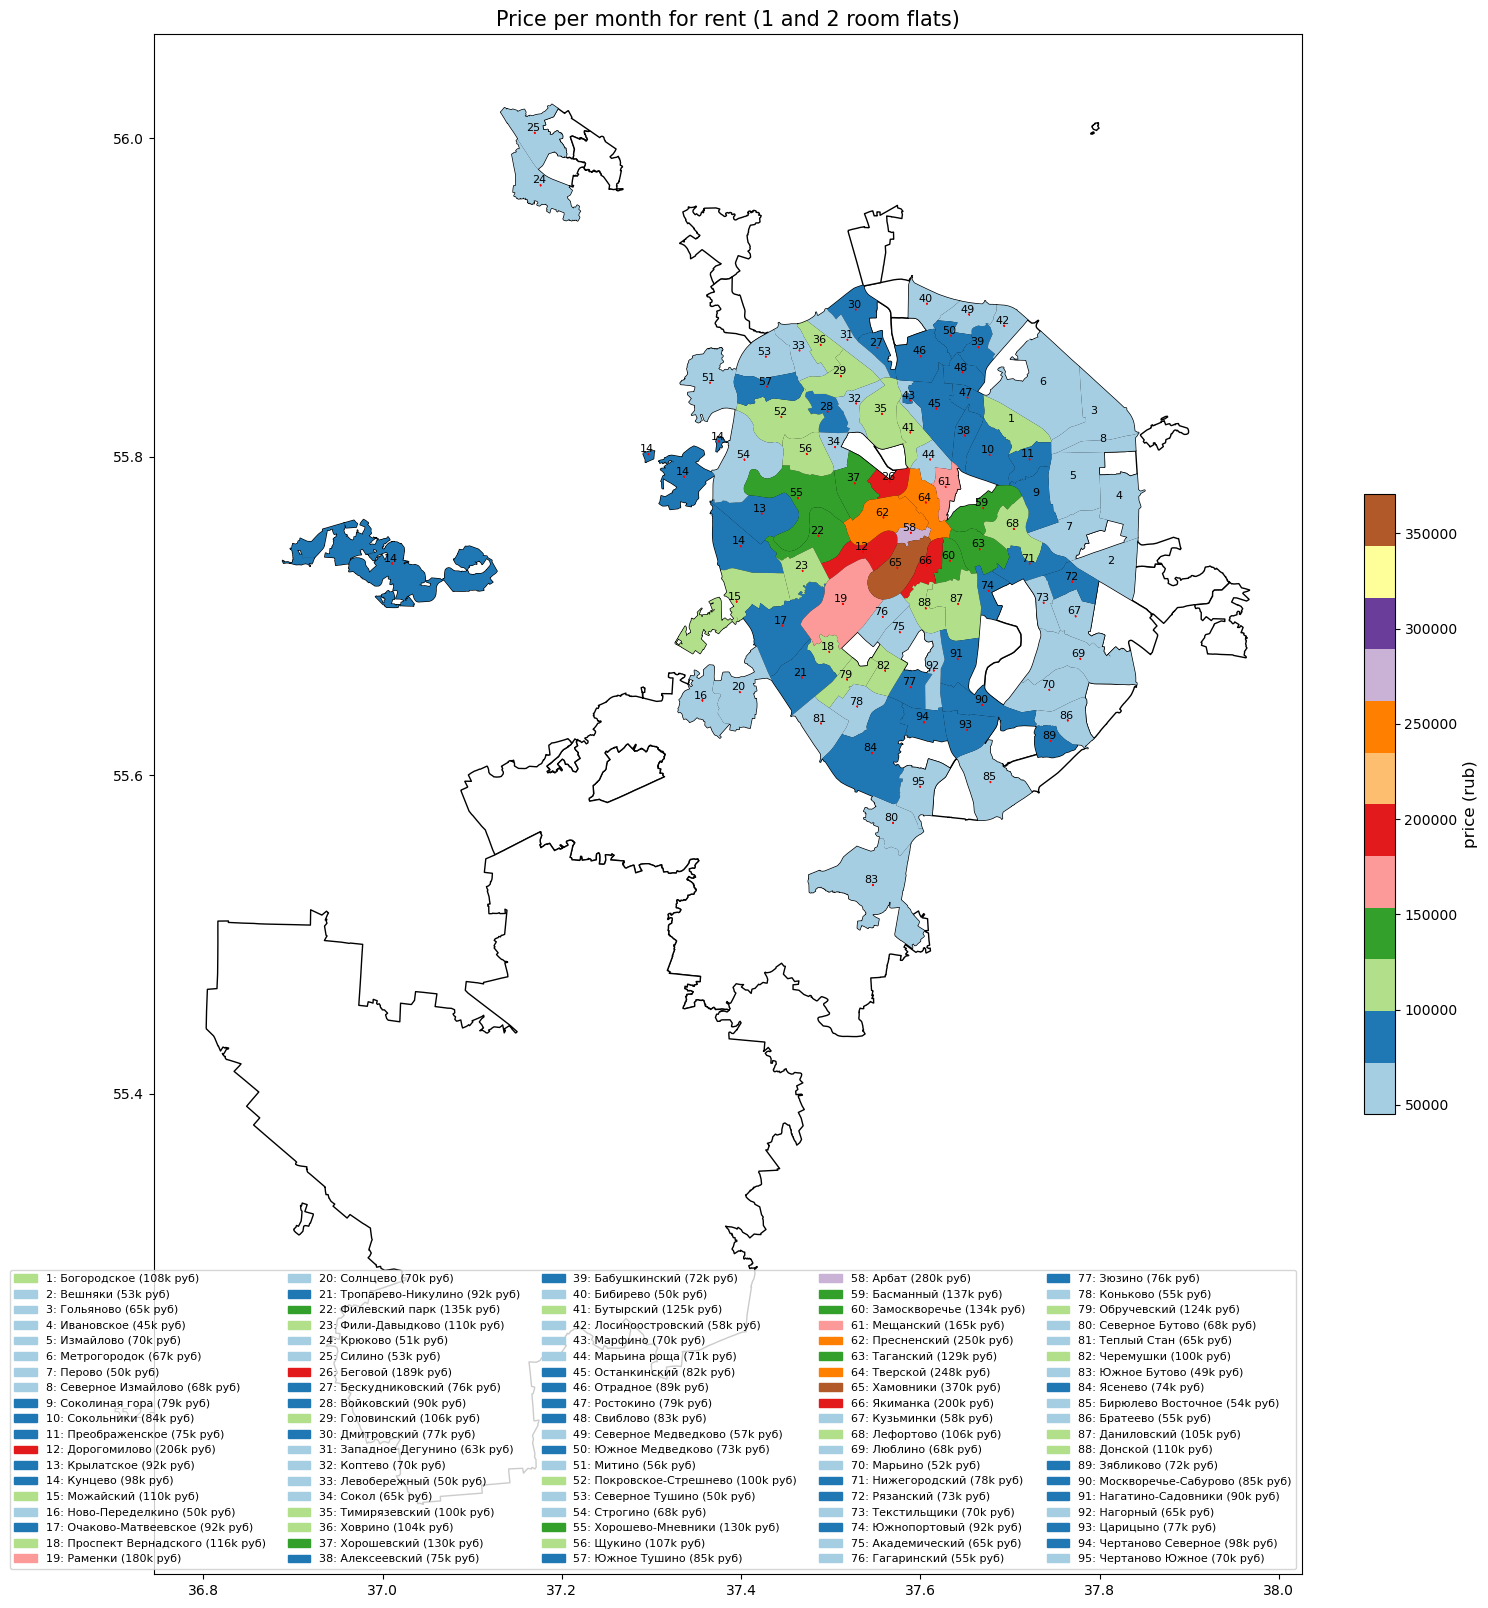

In [14]:
draw_map(data=rent_df, msc_data=MSC, header='Price per month for rent (1 and 2 room flats)')

As we can see on the map, the closer flat to the center of Moscow, the greater the price per month for it, and the further, the more human it becomes.

Now I want to check, which undergrounds 'are most expensive' by mean price per month for flat.

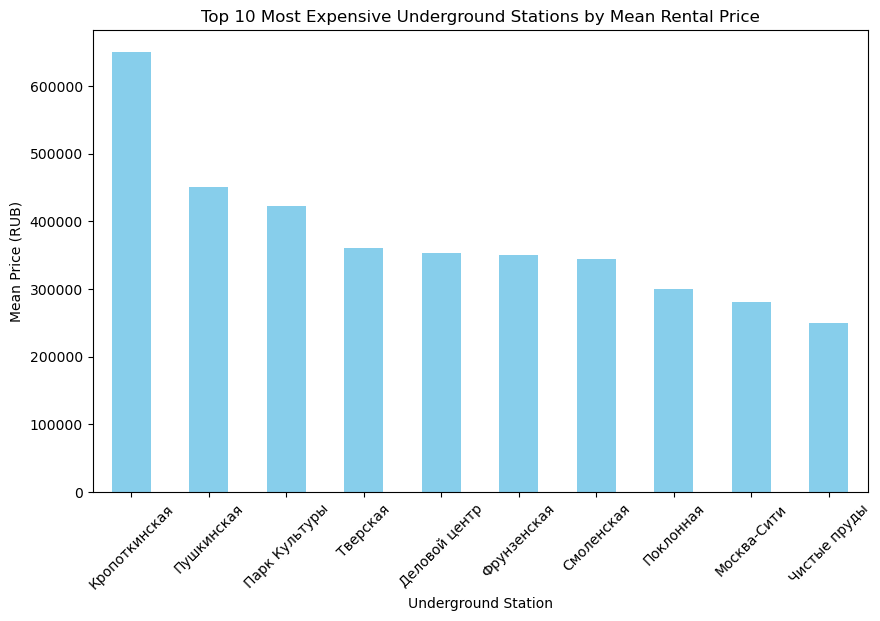

In [15]:
# Top 10 most expensive underground stations by mean price
mean_prices_by_station = rent_df.groupby('underground')['price'].mean()
mean_prices_by_station_sorted = mean_prices_by_station.sort_values(ascending=False)

mean_prices_by_station_sorted.head(10).plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Top 10 Most Expensive Underground Stations by Mean Rental Price')
plt.xlabel('Underground Station')
plt.ylabel('Mean Price (RUB)')
plt.xticks(rotation=45)
plt.show()

All this undergrounds are located near center of Moscow, which is not surprising.

As a result we get, that features, which influence price for rent the most, are total_size, distance to center and view (this flat for 1m rub). If you want to get more cheaper flat, just move slightly away from center.

### Priced for flats for sale

In this section I will do the same, but for flats, thar are for sale, and check, if the parameters, which influence, are the same.

In [16]:
# Descriptive statistics
sales_df['price'].describe()

count    2.730000e+02
mean     5.894193e+07
std      6.569725e+07
min      8.491900e+06
25%      2.575000e+07
50%      3.450000e+07
75%      6.000000e+07
max      5.142340e+08
Name: price, dtype: float64

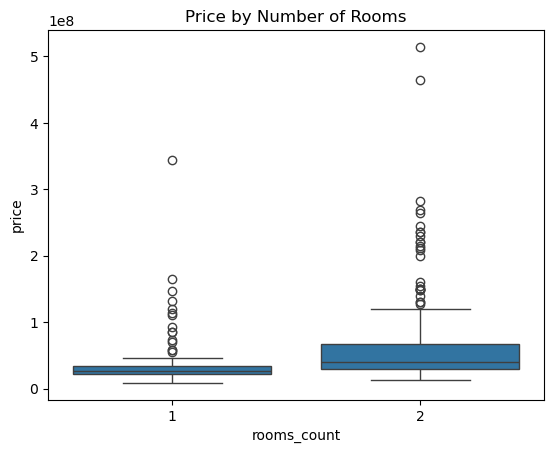

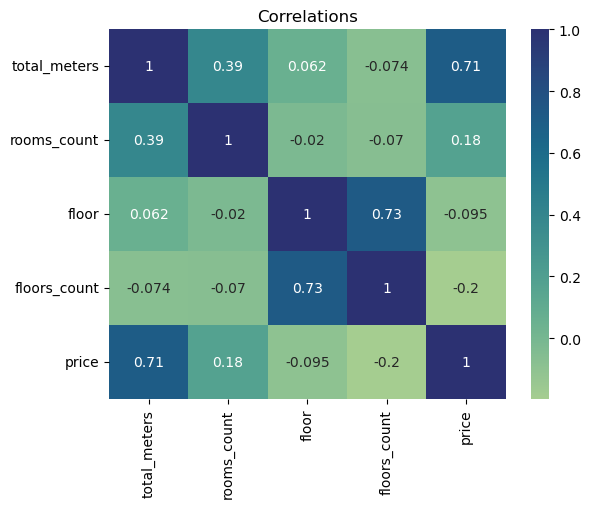

In [17]:
# Box plot: price by rooms_count
sns.boxplot(x='rooms_count', y='price', data=sales_df)
plt.title('Price by Number of Rooms')
plt.show()

# Correlation matrix
corr_matrix = sales_df[['total_meters', 'rooms_count', 'floor', 'floors_count', 'price']].corr()
sns.heatmap(corr_matrix, cmap='crest', annot=True)
plt.title('Correlations')
plt.show()

In [18]:
# Linear regression
X = sales_df[['total_meters', 'rooms_count', 'floor', 'floors_count']]
y = sales_df['price']
model = LinearRegression()
model.fit(X, y)
print("Coefficients:", model.coef_)

Coefficients: [  1860168.19892412 -18503766.27236971   -375229.5022234
   -345177.85941199]


As we can see, there is slightly different situation based on flats' characteristics. One square meter of flat costs on average 1.8m rub (1800$), and still unintuitive situation with `rooms_count`. Negative correlation with `floors_count` show, that people in Moscow probably dont like living in skyscrapers. As for floor, it has low absolute correlation, so we can assume, that it has zero influence.

Now lets check, how proximity to the center affect the price.


/tmp/ipykernel_3383/946895084.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  msc_exploded['centroid'] = msc_exploded.geometry.centroid


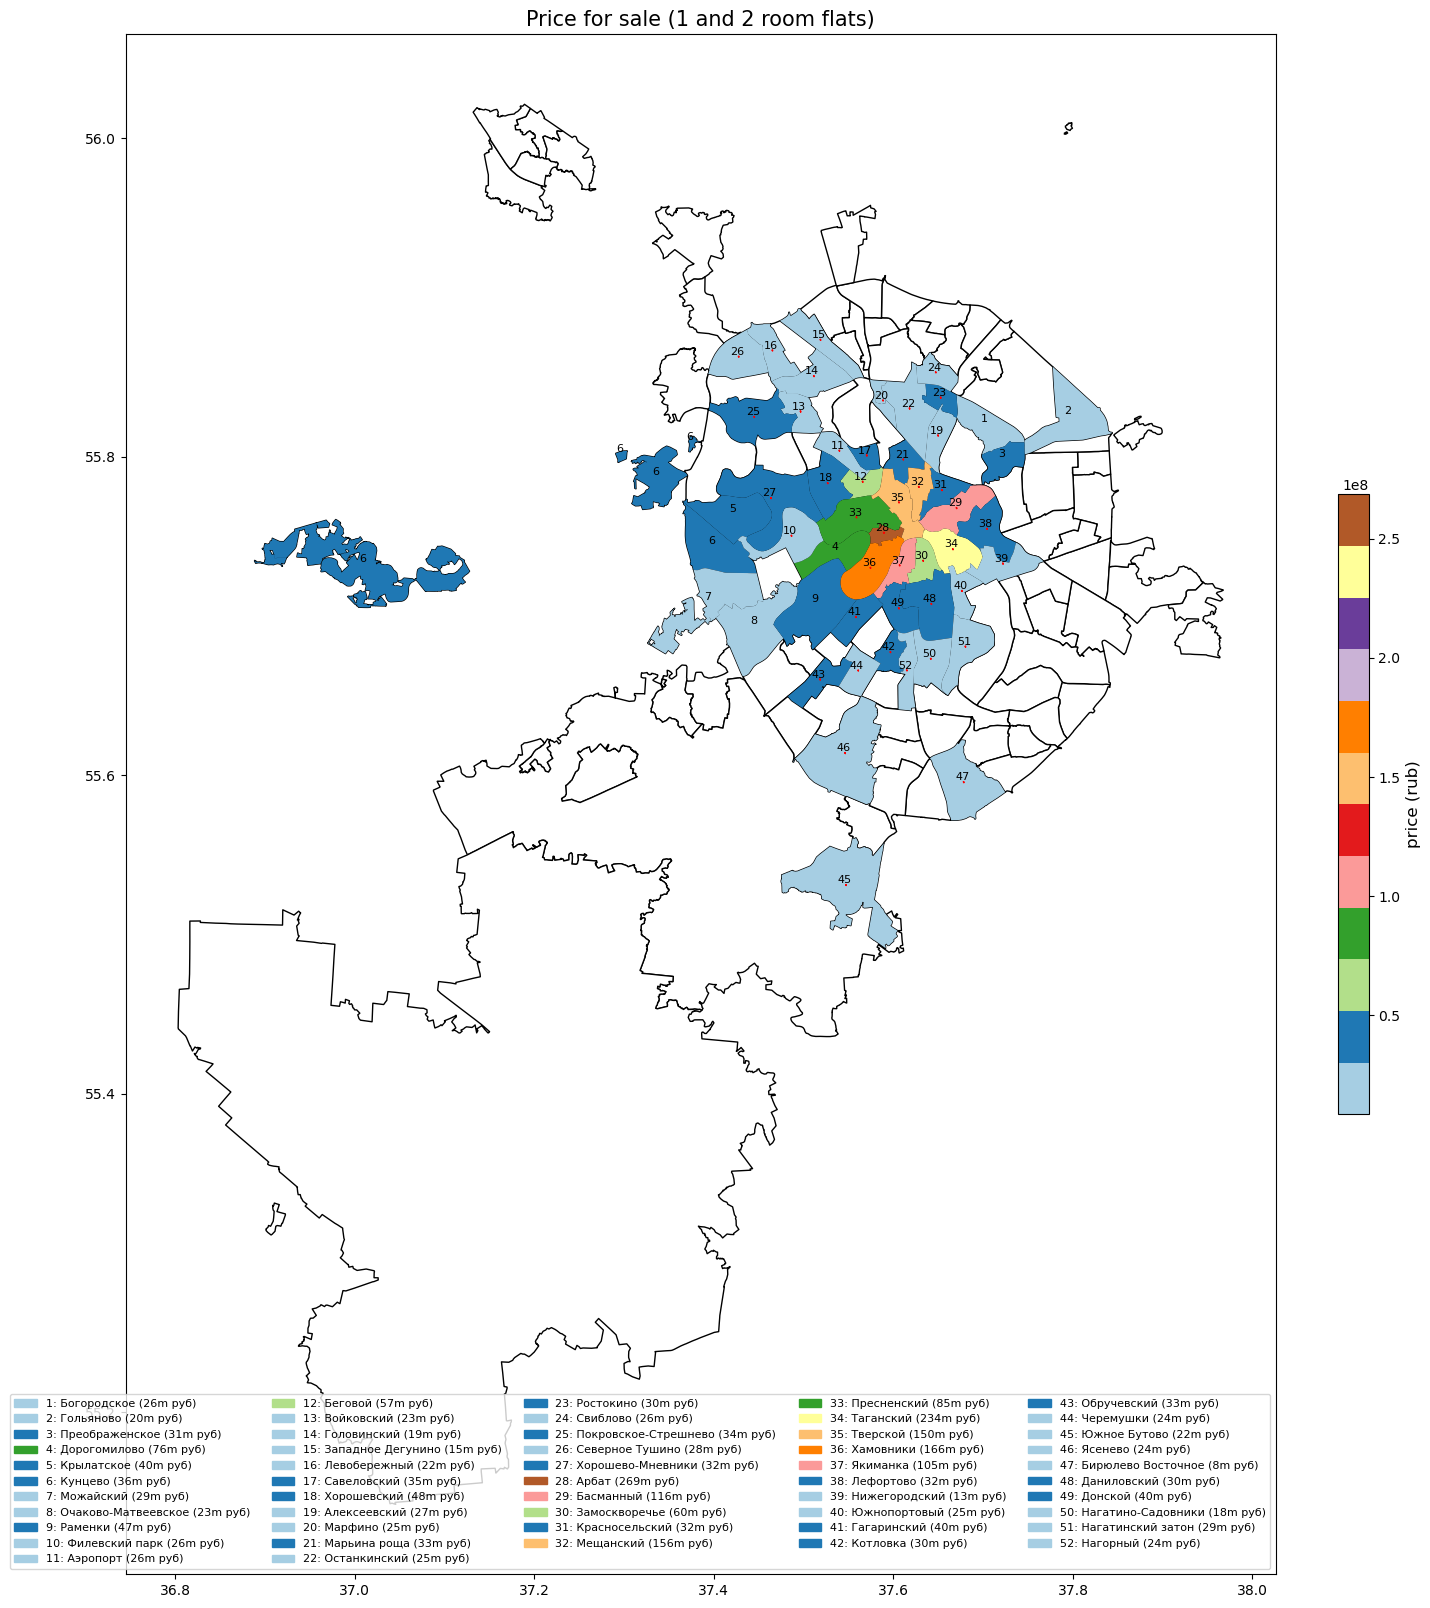

In [19]:
draw_map(data=sales_df, msc_data=MSC, header='Price for sale (1 and 2 room flats)')

As we can see, the proximity to the center increases the price more than 3 times.

## Conclusion
The analysis reveals that flat prices in Moscow are influenced by factors such as location, total meters, and the number of rooms. Visualizations help in understanding the distribution and correlations between different variables.

## References

- Cian: [Циан](https://www.cian.ru/)
- CianParser: [GitHub Repository](https://github.com/lenarsaitov/cianparser)
- Map of Moscow: [GitHub Repository](https://github.com/timurkanaz/Russia_geojson_OSM)